In [3]:
# Segment 1: Importing Libraries and Reading Data
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import BertTokenizer, BertModel
import numpy as np  # Add this import statement for NumPy
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

c:\Users\aryaa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Segment 2: Preprocessing Genres and Keywords
df = pd.read_csv("abc.csv")
df.head(1)
def genres_and_keywords_to_string(row):
    genres = row["genres"]
    if pd.isna(genres):
        genres = ""
    else:
        genres = json.loads(genres)
        genres = " ".join("".join(j["name"].split()) for j in genres)
    keywords = row["keywords"]
    if pd.isna(keywords):
        keywords = ""
    else:
        keywords = json.loads(keywords)
        keywords = " ".join("".join(j["name"].split()) for j in keywords)
    return "%s %s" % (genres, keywords)
df["string"] = df.apply(genres_and_keywords_to_string, axis=1)

DONT RUN CODE AGAIN SKIP PAST IT. TAKE 23 MINS TO RUN DUE TO DATABASE SIZE

In [5]:
# Segment 3: Generate BERT Embeddings
# tmdb_5000_movies
# Define maximum sequence length
MAX_SEQ_LENGTH = 128
def generate_bert_embeddings(row):
    if pd.isnull(row["overview"]):  # Check for missing values in the 'overview' column
        return None  # Return None if the 'overview' value is missing
    text = row["overview"]  # Get the overview column value
    # Tokenize input
    tokens = tokenizer.tokenize(text)
    # Truncate or pad the tokens to the specified max length
    tokens = tokens[: MAX_SEQ_LENGTH - 2]  # -2 for [CLS] and [SEP]
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids += [0] * (MAX_SEQ_LENGTH - len(input_ids))  # Pad tokens to the max length
    input_ids = torch.tensor([input_ids])
    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs[0][
            :, 0, :
        ].numpy()  # Extract embeddings of the first (and only) token [CLS]
    return embeddings
# Apply the function to each row of the DataFrame
df["bert_embeddings"] = df.apply(generate_bert_embeddings, axis=1)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


RUN FROM HERE. WILL STRAIGHT AWAY ASK FOR USER INPUT

In [6]:
import ast
# Segment 4: User Input and Querying
while True:
    try:
        input_movie = str(input("Enter movie title: "))
        idx = df[df["title"] == input_movie].index[0]
        break
    except IndexError:
        print("Wrong movie title. Please enter a valid movie title.")
query_embedding = df.at[idx, "bert_embeddings"]


In [7]:
# Segment 5: Calculate Cosine Similarity and Plot Scores
def calculate_cosine_similarity(query_embedding, embeddings):
    scores = []
    for embedding in embeddings:
        if embedding is not None:
            score = cosine_similarity([query_embedding], [embedding.reshape(-1)])
            scores.append(score[0][0])
        else:
            scores.append(np.nan)  # Handle missing embeddings
    return scores
scores = calculate_cosine_similarity(query_embedding.reshape(-1), df["bert_embeddings"])
print("Scores:", scores)  # Debugging statement to check the scores
 # Ensure plot is displayed

Scores: [1.0, 0.98322177, 0.9653914, 0.8608978, 0.8789828, 0.93620145, 0.27004206, 0.87577116, 0.97855043, 0.9010414, 0.90342087, 0.8471943, 0.9892572, 0.8482874, 0.8920321, 0.83599544, 0.88388294, 0.8722353, 0.3073612, 0.8650747, 0.28870907, 0.9177877, 0.97612196, 0.9719366, 0.9806117, 0.28763536, 0.95288515, 0.80878586, 0.98872644, 0.7449634, 0.8516745, 0.98953485, 0.31384113, 0.98888767, 0.9857006, 0.9859766, 0.8884105, 0.9610476, 0.8666314, 0.9586667, 0.9835478, 0.8805929, 0.927537, 0.93816364, 0.98147506, 0.88983655, 0.97273886, 0.6699121]


In [8]:
print(input_movie)
print(df.at[idx, "tagline"])
print("")
print("Summary: ")
print(df.at[idx, "overview"])
print("")
print("Review Score: ")
print(df.at[idx, "vote_average"])
print("")
print("Number Of Votes: ")
print(df.at[idx, "vote_count"])
print("")

Avatar
Enter the World of Pandora.

Summary: 
In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.

Review Score: 
7.2

Number Of Votes: 
11800



In [9]:
print("Genres are categorized based on summaries and reviews: ")
genres_list = ast.literal_eval(df.at[idx, "genres"])
for genre in genres_list:
    print(" - "+genre["name"])

Genres are categorized based on summaries and reviews: 
 - Action
 - Adventure
 - Fantasy
 - Science Fiction


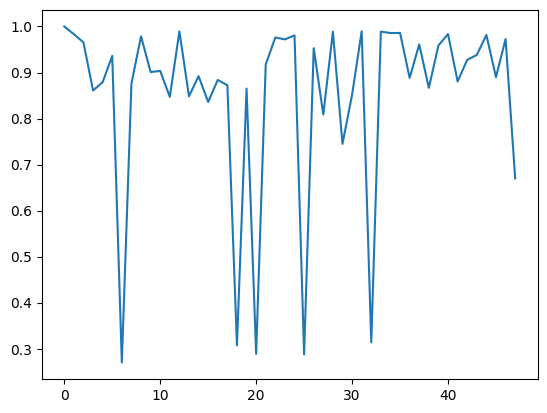

In [10]:
plt.plot(scores)
plt.show() 

In [11]:
# Segment 6: Recommend Top Titles
# Convert scores to a NumPy array
scores_array = np.array(scores)

# Get the indices of top recommendations
recommended_idx = (-scores_array).argsort()[1:6]

# Get the titles of the recommended movies
recommended_titles = df["title"].iloc[recommended_idx]

print("Top 5 Recommended Titles:")
print("--------------------------------------------------------------------------------------------------------------")
for i, idx in enumerate(recommended_idx, 1):
    print(f"{i}. {df.at[idx, 'tagline']}")
    print("")
    print("Summary: ")
    print(df.at[idx, "overview"])
    print("")
    print("Review Score: ")
    print(df.at[idx, "vote_average"])
    print("")
    print("Number Of Votes: ")
    print(df.at[idx, "vote_count"])
    print("")
    print("Genres from the above: ")
    genres_list = ast.literal_eval(df.at[idx, "genres"])
    for genre in genres_list:
        print(" - "+genre["name"])
    print("\n")
    print("--------------------------------------------------------------------------------------------------------------")

Top 5 Recommended Titles:
--------------------------------------------------------------------------------------------------------------
1. Unleash the power behind the armor.

Summary: 
When Tony Stark's world is torn apart by a formidable terrorist called the Mandarin, he starts an odyssey of rebuilding and retribution.

Review Score: 
6.8

Number Of Votes: 
8806

Genres from the above: 
 - Action
 - Adventure
 - Science Fiction


--------------------------------------------------------------------------------------------------------------
2. Jack is back!

Summary: 
Captain Jack Sparrow works his way out of a blood debt with the ghostly Davey Jones, he also attempts to avoid eternal damnation.

Review Score: 
7.0

Number Of Votes: 
5246

Genres from the above: 
 - Adventure
 - Fantasy
 - Action


--------------------------------------------------------------------------------------------------------------
3. Take a Stand

Summary: 
When a cure is found to treat mutations, lines are 